In [ ]:
%%bash
git clone --recursive https://github.com/pytorch/pytorch
cd pytorch
# if you are updating an existing checkout
git submodule sync
git submodule update --init --recursive --jobs 0

Process is interrupted.


In [ ]:
%%bash
cd pytorch
python setup.py install

Process is interrupted.


In [ ]:
%matplotlib inline
import os
import cv2
import torch
import random
import torch.onnx
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm, trange
import torchvision.transforms.functional as F
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
import sys
sys.path.append('./')
#from engine import train_one_epoch, evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Helpers function from Pytorch**

In [ ]:
%%shell
 
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
 
cp references/detection/utils.py .
cp references/detection/transforms.py .
cp references/detection/coco_eval.py .
cp references/detection/engine.py .
cp references/detection/coco_utils.py .

In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/transforms.py" .
!cp "/content/drive/My Drive/Colab Notebooks/coco_eval.py" .
!cp "/content/drive/My Drive/Colab Notebooks/coco_utils.py" .
!cp "/content/drive/My Drive/Colab Notebooks/utils.py" .
!cp "/content/drive/My Drive/Colab Notebooks/engine.py" .

In [ ]:
from engine import train_one_epoch, evaluate

# **Dataset Class**

In [ ]:
class CocoaDataset(CocoDetection):
 
    def __init__(self, root, annFile,transform = None, target_transform = None):
        super().__init__(root, annFile, transform, target_transform)
 
 
    def __getitem__(self, index):
        
        img, target = super().__getitem__(index)
        img_id = self.ids[index]
        boxes = []
        labels = []
        masks = []
        areas = []
        iscrowds = []
        for ann in target:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x+w, y+h])
            areas.append(ann['area'])
            labels.append(ann['category_id'])
            iscrowds.append(ann['iscrowd'])
            masks.append(self.coco.annToMask(ann))
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        areas = torch.as_tensor(areas, dtype = torch.float32)
        iscrowds = torch.as_tensor(iscrowds, dtype = torch.int64)
        labels = torch.as_tensor(labels, dtype = torch.int64)
        masks = torch.as_tensor(masks, dtype = torch.uint8)
        img_id = torch.tensor([img_id])
 
        # Annotation in dict format and values in dtype = tensor
        target = {}
        target['image_id'] = img_id
        target['labels'] = labels
        target['iscrowd'] = iscrowds
        target['area'] = areas
        target['boxes'] = boxes
        target['masks'] = masks
        return img, target
    
    def __len__(self):
        return super().__len__()

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

## **Load traning and validate dataset**

In [ ]:
train_data_dir = path+'DataSets/cocoa_diseases_dataset/train/images'
train_coco_ann = path+'DataSets/cocoa_diseases_dataset/train/COCO_train.json'
val_data_dir = path+'DataSets/cocoa_diseases_dataset/val/images'
val_coco_ann = path+'DataSets/cocoa_diseases_dataset/val/COCO_val.json'
 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}
train_set = CocoaDataset(train_data_dir, train_coco_ann, transform=data_transforms['train'])
 
val_set = CocoaDataset(val_data_dir, val_coco_ann, transform = data_transforms['val'])
 
train_loader = data.DataLoader(train_set, batch_size = 1, shuffle = True, num_workers=4,
                                          collate_fn=collate_fn)
 
val_loader = data.DataLoader(val_set, batch_size = 1, shuffle = False, num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=2.50s)
creating index...
index created!
loading annotations into memory...
Done (t=1.46s)
creating index...
index created!


# **Download the Pre-trained Model**
*we have 3 classes + 1(background)*

In [ ]:
num_classes = 4
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

In [ ]:
def train(model,train_loader, val_loader, lr = 0.005, num_epochs = 20):
    
    optimizer = torch.optim.SGD(model.parameters(), 
                            lr = lr, momentum=0.9, 
                            weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=500)
        # Save the model after each epoch and update the learning rate
        torch.save(model, path+"trained/cocoa_diseases_model.pth")
        torch.save(model.state_dict(), path+"trained/cocoa_diseases_state_dict.pth")
        lr_scheduler.step()
        evaluate(model, val_loader, device=device)

    ''' Using our custom training loop'''
    # for epoch in trange(num_epochs):
    #     for images, annotations in tqdm(train_loader):
    #         optimizer.zero_grad()
    #         images = list(img for img in images)
    #         annotations = [{k: v for k, v in t.items()} for t in annotations]
    #         #print(images)
    #         #print(annotations)
    #         loss_dict = model(images, annotations)

    #         losses = sum(loss for loss in loss_dict.values())
    #         #print(output)
    #         losses.backward()
    #         optimizer.step()
    #            evaluate(model, val_loader, device=device)
    #         print(f'Epoch: {epoch+1}/{len(dataloader)}, lr: {optimizer.param_groups[0]["lr"]}, Loss: {losses}, loss_classifier: {loss_dict["loss_classifier"]}, loss_box_reg: {loss_dict["loss_box_reg"]}, loss_mask: {loss_dict["loss_mask"]}, loss_objectness: {loss_dict["loss_objectness"]}, loss_rpn_box_reg: {loss_dict["loss_rpn_box_reg"]}')
    #     lr_scheduler.step()

# **Load the last version of the model and continue the training**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.load_state_dict(torch.load(path+"trained/cocoa_diseases_state_dict.pth",  map_location=device))

<All keys matched successfully>

In [ ]:
train(model= model,lr=0.000001, train_loader= train_loader, val_loader = val_loader, num_epochs=50)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [   0/1930]  eta: 0:53:29  lr: 0.000000  loss: 0.3692 (0.3692)  loss_classifier: 0.1073 (0.1073)  loss_box_reg: 0.0709 (0.0709)  loss_mask: 0.1778 (0.1778)  loss_objectness: 0.0087 (0.0087)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.6629  data: 1.3020  max mem: 970
Epoch: [0]  [ 500/1930]  eta: 0:07:36  lr: 0.000001  loss: 0.5599 (0.5104)  loss_classifier: 0.0666 (0.0967)  loss_box_reg: 0.0881 (0.0878)  loss_mask: 0.2987 (0.2975)  loss_objectness: 0.0095 (0.0237)  loss_rpn_box_reg: 0.0015 (0.0047)  time: 0.3367  data: 0.2417  max mem: 1655
Epoch: [0]  [1000/1930]  eta: 0:04:49  lr: 0.000001  loss: 0.4788 (0.4900)  loss_classifier: 0.0929 (0.0921)  loss_box_reg: 0.0750 (0.0852)  loss_mask: 0.2661 (0.2852)  loss_objectness: 0.0077 (0.0226)  loss_rpn_box_reg: 0.0021 (0.0048)  time: 0.2352  data: 0.1414  max mem: 1655
Epoch: [0]  [1500/1930]  eta: 0:02:09  lr: 0.000001  loss: 0.3129 (0.4824)  loss_classifier: 0.0510 (0.0891)  loss_box_reg: 0.0368 (0.0839)  loss_mask: 0.2135 (0

# **Save the final version of the model**

In [ ]:
torch.save(model, path+'trained/cocoa_diseases_model.pth')
torch.save(model.state_dict, path+'trained/cocoa_diseasis_state_dict.pth')

In [ ]:
def get_prediction(img_path, threshold):
    """
        Detect diseases on image as needed
        :param frame: image path
        :return 
          masks : the detected mask 
          boxes : the detected boxes
          labels : labels classification
          scores : corresponding scores
    """
    class_names = ['__background__', 'Cocoa', 'Pod Borer', 'Black Pod Rot']
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.ToTensor()])
    img = transform(img)

    model.eval()
    pred = model([img])
    scores = list(pred[0]['scores'].detach().numpy())
    pred_t = [scores.index(x) for x in scores if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [class_names[i] for i in list(pred[0]['labels'].numpy())]

    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class


In [ ]:
def colour_masks(image, pred_class):
    colours = [[204, 0, 0],[255, 255, 0],[105,105,105]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    if pred_class == 'Cocoa':
        r[image == 1], g[image == 1], b[image == 1] = colours[0]
    if pred_class == 'Pod Borer':
        r[image == 1], g[image == 1], b[image == 1] = colours[1]
    if pred_class == 'Black Pod Rot':
        r[image == 1], g[image == 1], b[image == 1] = colours[2]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

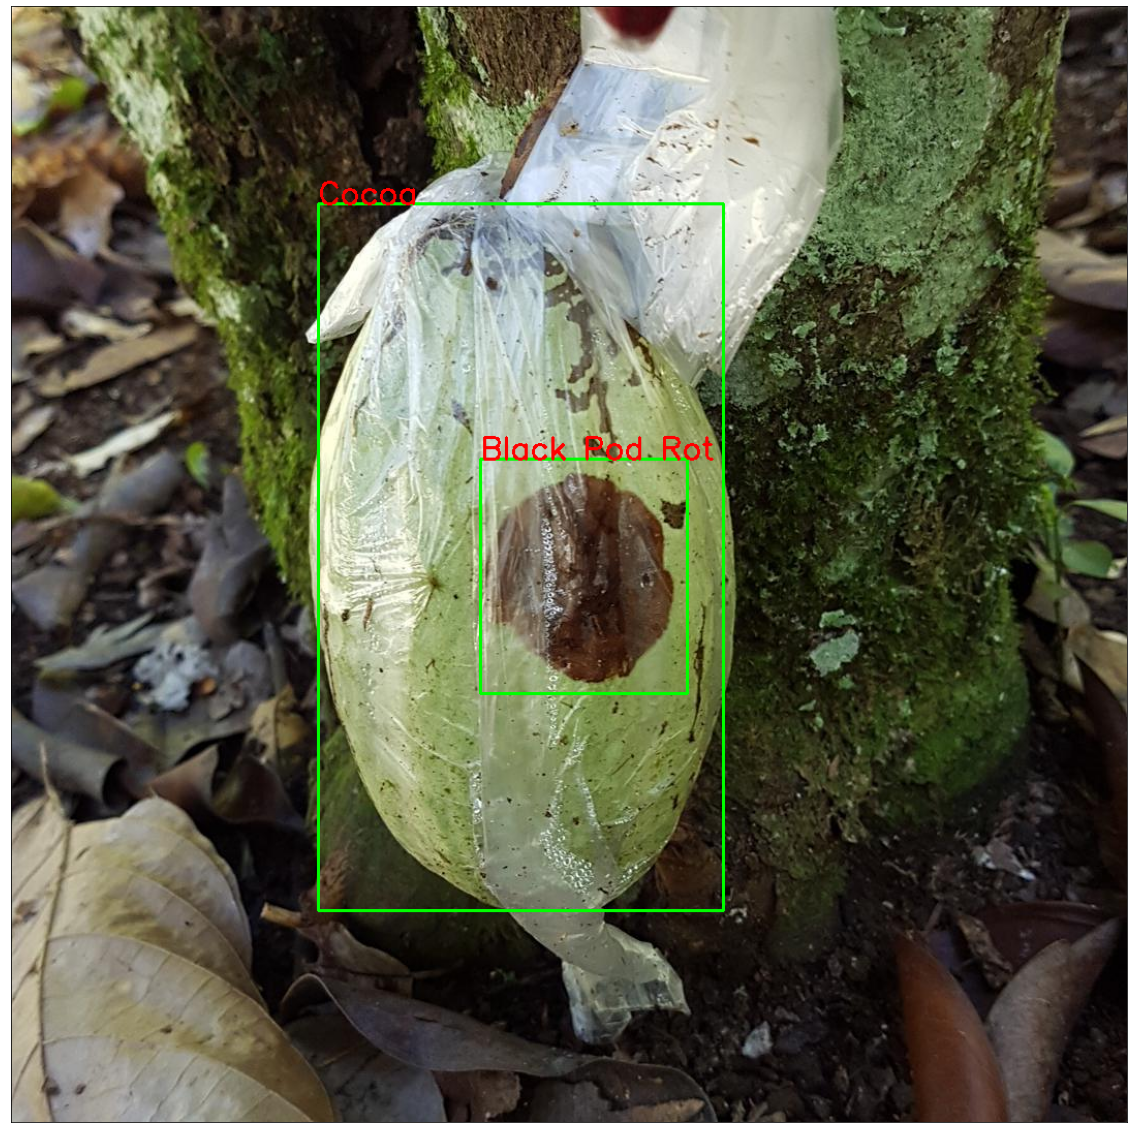

In [ ]:
val_data_dir = 'cocoa_diseases_dataset/val/images/'
img_path = 'cocoa_diseases_dataset/black_pod_rot_894.jpg'
#masks, boxes, classes = get_prediction(img_path=img_path, threshold=0.9)
#print(classes)
masks, boxes, pred_cls = get_prediction(img_path, threshold=0.7)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for i in range(len(masks)):
    #boxes = boxes[i][0]
    pred_class = pred_cls[i]
    #print(pred_class)
    rgb_mask = colour_masks(masks[i], pred_class)
    img = cv2.addWeighted(img, 1, rgb_mask, 0., 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=2)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),thickness=2)
    
    
plt.figure(figsize=(20,30))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()


# **Convert the model to ONNX model**

In [ ]:
# Export the model to ONNX model
batch_size = 1
x = torch.randn(batch_size, 3, 1080, 1080, requires_grad=True)

model.eval()
model_onnx_path = "model_onnx_path.onnx"

torch.onnx._export(
    model,
    x,
    path+"trained/cocoa_diseases_model.onnx",
    export_params=True,
    opset_version=11,
    verbose=False,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output'],
    dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
)


# **Install OpenVino**

In [ ]:
%%time
%%capture
## install tools. Open Vino takes some time to download: 10-15 min sometimes.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## downnload installation files
!wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16345/l_openvino_toolkit_p_2020.1.023.tgz
# !wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16612/l_openvino_toolkit_p_2020.2.120.tgz
# !wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16803/l_openvino_toolkit_p_2020.4.287.tgz
path = "l_openvino_toolkit_p_2020.1.023.tgz"
# path = "l_openvino_toolkit_p_2020.2.120.tgz"
# path = "l_openvino_toolkit_p_2020.4.287.tgz"
# path = "/content/software/Intel OpenVINO 2019 R3.1/l_openvino_toolkit_p_2019.3.376.tgz"
## install openvino
!tar xf "{path}"
%cd l_openvino_toolkit_p_2020.1.023/
# %cd l_openvino_toolkit_p_2020.4.287/
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

CPU times: user 534 ms, sys: 148 ms, total: 682 ms
Wall time: 1min 43s


# **Convert the model Into IR**

In [ ]:
!source /opt/intel/openvino/bin/setupvars.sh && \
    python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model  "/content/drive/MyDrive/Colab Notebooks/cocoa_diseases/models/mask_rcnn_inception_resnet_v2/model_saved/saved_model/saved_model.pb" \
--model_name cocoa_diseases_model.onnx \
--data_type FP16 \
--reverse_input_channel \
--output_dir /content/

In [ ]:
def get_prediction(frame):
    """
        Detect diseases on image as needed
        :param frame: from cv2.VideoCapture().read(
        :return 
          masks : the detected mask 
          boxes : the detected boxes
          labels : labels classification
          scores : corresponding scores
    """
    class_names = ['__background__', 'Cocoa', 'Pod Borer', 'Black Pod Rot']
    
    transform = transforms.Compose([
        transforms.ToTensor()])
    img = transform(frame)
 
    model.eval()
    pred = model([img])
    scores = list(pred[0]['scores'].detach().numpy())
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    labels = list(pred[0]['labels'].numpy())
 
    boxes = list(pred[0]['boxes'].detach().numpy())
    return boxes, masks, labels, scores

In [18]:
val_data_dir = 'cocoa_diseases_dataset/val/images/'
img_path = 'black_pod_rot_657.jpg'
class_names = ['__background__', 'Cocoa', 'Pod Borer', 'Black Pod Rot']
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/DataSets/input.mp4')
frame_height = int(cap.get(4))
frame_width = int(cap.get(3))
res=(frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/DataSets/output.mp4', fourcc, 20.0, res)
if cap.isOpened()==False:
    print("Error opening the video stream od file.")
 
while(cap.isOpened()):
    flag, frame = cap.read()
    if not flag:
        break
    boxes,masks, labels, scores = get_prediction(frame)
    for i in range(len(boxes)):
      if scores[i]>=0.5:
        label = class_names[labels[i]]
        xmin, ymin, xmax, ymax = boxes[i]
        rgb_mask = colour_masks(masks[i], label)
        frame = cv2.addWeighted(frame, 1, rgb_mask, 0., 0)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax),color=(0, 255, 0), thickness=2)
        text = label+' '+str("{:.1f}".format(scores[i]*100))+'%'
        cv2.putText(frame,text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),thickness=2)
      out.write(frame)  
cap.release()
out.release()
cv2.destroyAllWindows()  